In [1]:
import Pkg; Pkg.activate(joinpath(@__DIR__,".")); Pkg.instantiate();
using LinearAlgebra;
using Plots;
using StaticArrays;
using ForwardDiff;
using RobotZoo;
using RobotDynamics;
using MeshCat;
using TrajOptPlots;
using MathOptInterface;
const MOI = MathOptInterface
using Ipopt;

 Activating environment at `C:\Users\brand\OneDrive\Documents\College Stuff\16-745\final-project\Project.toml`


We know the dynamics are of the following:
            $$q = \begin{bmatrix}
                  x_{foot}    \\
                  y_{foot}   \\
                  \alpha \\
                  \beta  \\
                  \end{bmatrix}$$
where $\alpha$ is the top revolute joint and $\beta$ is the middle revolute joint
And normally for a single dynamics phase,
$$ dx = \delta_{(x, 1)} f_{1}(x, u) + \delta_{(x, 2)} f_{2}(x, u)$$

which is pretty much a guard function.

           
           
           
           
           

In [61]:
struct Hopper
    ml
    l
    function Hopper(ml, l)
        new(ml, l)
    end
end


function dynamics_hop(hopper, x, u, λ)
    m = hopper.ml
    l = hopper.l
    
    # q = x[1:4]
    r1 = x[1]
    r2 = x[2]
    t1 = x[3]
    t2 = x[4]
    
    # qdot = x[5:8]
    r1dot = x[5]
    r2dot = x[6]
    t1dot = x[7]
    t2dot = x[8]
    
    g = 9.81
    # Following the formage of lagrangian,
    M = m/2 * [4.0       0.0        -l*cos(t1)       -l*cos(t2);
               0.0       4.0        -l*sin(t1)       -l*sin(t2);
              -l*cos(t1) -l*sin(t1)  5*l^2/2          l^2*cos(t1-t2)
              -l*cos(t2) -l*sin(t2)  l^2/2*cos(t1-t2) 5*l^2/2]
    n = [l*sin(t1)*(t1dot)^2 + l*sin(t2)*(t2dot)^2;
        -l*cos(t1)*(t1dot)^2 - l*cos(t2)*(t2dot)^2;
        (l^2)/2*(t2dot)^2*sin(t1-t2) - (l^2)/2*t1dot*t2dot*sin(t1-t2) + r1dot*l*sin(t1)*t1dot - r2dot*l*cos(t2)*t2dot;
        (l^2)/2*(t1dot)^2*sin(t1-t2) + (l^2)/2*t1dot*t2dot*sin(t1-t2) + r1dot*l*sin(t2)*t2dot - r2dot*l*sin(t2)*t2dot]
    
    dLdq = [0;
           -2*m*g;
           ((t1dot)^2)*(-(l^2)/2*t2dot*sin(t1-t2) + r1dot*l*sin(t1) - r1dot*l*cos(t1)) + m*g*l/2*sin(t1)*t1dot;
           ((t2dot)^2)*(l^2/2*t1dot*sin(t1-t2) + r1dot*l*cos(t2) - r2dot*l*cos(t2)) + m*g*l/2*sin(t2)*t2dot]
    B = [0 0 0 0;
         0 0 0 0;
         0 0 1 0;
         0 0 0 1]
    J = [1 0 l*cos(t1) 0;
         0 1 l*sin(t1) 0]
    
    qdd = M \ (B*u + J'*λ + dLdq - n)
    qd = x[5:8]
    return [qd; qdd]
end
        


function jump_map(x)
    xn = [x[1:4]; 0.0; 0.0; x[7:8]]
    return xn
end


function implicit_euler_dynamics(hopper, x1, x2, u, λ, h)
    return x1 .+ h*dynamics_hop(x2, u, λ)
end


function implicit_euler_solve(hopper, xguess, u, λguess, h; inair=false, tol=1e-3)
    l = hopper.l
    count = 0
    xb = copy(xguess)
    if inair
        λb = zeros(eltype(λguess), length(λ))
    else
        λb = copy(λguess)
    end
    
    residual = implicit_midpoint_dynamics(hopper, xguess, xb, u, λguess, λguess, h) .- xguess
    while norm(residual) > tol && count < 10
        if inair
            dLdx = I(8) - h * ForwardDiff.jacobian(inX->dynamics_hop(inX, u, λb), xb)
            Δx = dLdx \ residual
            xb .= xb .+ Δx
        else
            t1 = xb[2]
            t1dot = xb[7]
            dLdx = I(8) - h * ForwardDiff.jacobian(x->dynamics_hop(x, u, λb), xb)
            dLdl = -h * ForwardDiff.jacobian(l->dynamics_hop(xb, u, l), λb)
            dCdx = zeros(8)
            dCdx[2] = 1.0
            dCdx[3, 3] = l/2*sin(t1)*t1dot
        


function foot_coords(hopper, x)
    l = hopper.l
    
    r1 = x[1]
    r2 = x[2]
    t1 = x[3]
    t2 = x[4]
    
    f1 = r1 + l/2*sin(t1)
    f2 = r2 - l/2*cos(t1)
    h1 = r1 - l/2*sin(t1) - l*sin(t2)
    h2 = r2 + l/2*cos(t1) + l*cos(t2)
    return [f1; f2; h1; h2]
end


foot_coords (generic function with 1 method)

In [64]:
# Test the foot coords. The description for both is from the vertical
begin
    l = 1.0
    t1 = pi/4
    t2 = -pi/4
    x0 = [-l/2*sin(t1); l/2*cos(t1); t1; t2; 0.0; 0.0; 0.0; 0.0]
    println(x0)
    hopper = Hopper(1, 1)
    fx = foot_coords(hopper, x0)
    # regCoords = foot_coords(hopper, fx)
    println(fx)
    u = [0.0; 0.0; 1.0; 1.0]
    λ = zeros(2)
    println(dynamics_hop(hopper, x0, u, λ))
    # 3 println(regCoords)
end

[-0.35355339059327373, 0.3535533905932738, 0.7853981633974483, -0.7853981633974483, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 1.4142135623730951]
[0.0, 0.0, 0.0, 0.0, 0.3142696805273545, -10.9, -2.194096677084458, 3.971874454862236]


In [142]:
# Testing for any sort of flight
begin
    x0 = [0; 0; 3*pi/4; -pi/2; 0; 0; 0; 0]
    # u0 = 2
    h = 0.1
    hopper = Hopper(1, 2, 1, 0.5, 0.5)
    x = x0
    # println(x)
    acon = -10
    bcon = -10
    for i = 1:20
        for j = 1:20
            newX = copy(x0)
            u = [acon, bcon]
            acon += 1
            bcon += 1
            rk4_dynamics!(hopper, newX, u, true, h)
            # println(newX[2])
            if (newX[2] >= 0)
                println(u)
                println(newX[1])
                println(newX[2])
            end
        end
    end
end

[121, 121]
-0.5062067904676392
0.00044541194892027867
[122, 122]
-0.4818352404963117
0.049833045045068046
[123, 123]
-0.4555881418872904
0.10149199719632437
[124, 124]
-0.4274164809004884
0.15546680287893372
[125, 125]
-0.39727149674407697
0.21180172875276693
[126, 126]
-0.3651047301973198
0.2705407528703469
[127, 127]
-0.33086807229471954
0.33172754466167287
[128, 128]
-0.29451381299070334
0.3954054457044681
[129, 129]
-0.2559946897250189
0.46161745128493115
[130, 130]
-0.2152639358100931
0.5304061927498109
[131, 131]
-0.17227532856313815
0.6018139206461441
[132, 132]
-0.12698323710736417
0.6758824886407883
[133, 133]
-0.07934266976879292
0.7526533382075282
[134, 134]
-0.02930932099737898
0.8321674840652019
[135, 135]
0.0231603822564584
0.9144655003464885
[136, 136]
0.07810923477589982
0.9995875074726601
[137, 137]
0.13557920798563747
1.0875731597060176
[138, 138]
0.1956114055936229
1.1784616333477873
[139, 139]
0.258246020023443
1.2722916155459545
[140, 140]
0.32352228969062014
1.369

[306, 306]
23.436314550673764
47.860201556123556
[307, 307]
23.06495126778417
47.77443235254575
[308, 308]
22.673591209882193
47.67015426149133
[309, 309]
22.261855036843077
47.54704791379212
[310, 310]
21.829362911706895
47.40479839210553
[311, 311]
21.375734780848166
47.243095544130334
[312, 312]
20.9005906648021
47.061634294749915
[313, 313]
20.403550959563017
46.86011495646378
[314, 314]
19.884236748128
46.63824353744563
[315, 315]
19.342270122024246
46.39573204656055
[316, 316]
18.777274512512943
46.13229879465703
[317, 317]
18.18887503113164
45.847668691449805
[318, 318]
17.57669881918795
45.54157353729555
[319, 319]
16.940375405786405
45.213752309169514
[320, 320]
16.279537073919993
44.863951440140816
[321, 321]
15.59381923413018
44.49192509165708
[322, 322]
14.882860805188315
44.09743541794544
[323, 323]
14.146304601220674
43.68025282184908
[324, 324]
13.383797724662145
43.24015620143433
[325, 325]
12.59499196437707
42.77693318670266
[326, 326]
11.779544198268194
42.29038036578

In [178]:
# Test one good flight number 
begin
    x0 = [0; 0; 3*pi/4; -pi/2; 0; 0; 0; 0]
    # u0 = 2
    h = 0.1
    hopper = Hopper(1, 2, 1, 0.5, 0.5)
    x = x0
    # println(x)
    acon = -10
    bcon = -10
    u = [123.0, 123.0]
    for i = 1:20
        if mod(i, 5) == 1
            u = [123.0, 123.0]
        else
            u = [-123.0, -123.0]
        end
        println(u)
        println(x)
        rk4_dynamics!(hopper, x, u, true, h)
        # println(s)
    end
    
end

[123.0, 123.0]
[0.0, 0.0, 2.356194490192345, -1.5707963267948966, 0.0, 0.0, 0.0, 0.0]
Change[0.17608478887640058, 0.14469815315703646, -0.04881172439773591, 2.6530044322302824, -6.823480342323674, 8.776828694915466, -7.930911738538057, 55.88308478952728]
[-123.0, -123.0]
[0.17608478887640058, 0.14469815315703644, 2.307382765794609, 1.0822081054353858, -6.823480342323674, 8.776828694915464, -7.9309117385380565, 55.883084789527274]
Change[5776.998462107512, 699.8398348096598, 6247.636738450769, -7930.459419589814, -2.378404296176536e9, -4.503379023572549e9, 5.398828082233418e9, -4.525195120354615e9]
[-123.0, -123.0]
[5777.174546896388, 699.9845329628168, 6249.944121216563, -7929.377211484378, -2.378404303000016e9, -4.503379014795719e9, 5.3988280743025055e9, -4.52519506447153e9]
Change[-2.692098747217543e59, -1.4514290190103028e60, 1.6504297612976704e60, -2.0385557723152163e60, 2.2611181520743873e121, 1.4038883055388794e122, -1.1230511130958952e121, 8.527234236732118e120]
[-123.0, -123.0]

## Stance and flight test with random control input

In [162]:
# Stance and flight test
begin
    x0 = [0; 0; 3*pi/4; -pi/2; 0; 0; 0; 0]
    # u0 = 2
    h = 0.1
    hopper = Hopper(1, 2, 1, 0.5, 0.5)
    T = 40
    modes = zeros(T)
    
    m = 1
    change = 1
    for i = 1:T
        modes[i] = m
        if mod(i, 5) == 0
            m += change
            # println("flop")
            change = change * -1
        end
    end      
        
    Xs = zeros(T, 8)
    println("Begin")
    Fxs = zeros(T, 8)
    x = x0
    # println(x)
    Xs[1, :] .= x0
    u = [0.0; 0.0]
    for i = 2:T
        if modes[i] == 1
            x[5:6] .= 0.0
            u = [-10.0; 5.0]
            rk4_dynamics!(hopper, x, u, false, h)
            println(x)
        else
            # println("Flying")
            u = [0.0; 0.0]
            rk4_dynamics!(hopper, x, u, true, h)
            # println("flight")
        end 
        Xs[i, :] .= x
        Fxs[i, :] .= foot_coords(hopper, x)
    end
    ths = [SVector{4}([Xs[i, 3]; Xs[i, 4]; Xs[i, 7]; Xs[i, 8]]) for i = 1:T]
    TrajOptPlots.set_mesh!(vis, a)
    visualize!(vis, a, T*h, ths)
    # plot(Ths[:, 1:2])
    # println(Xs[:, 6])
    plot(Xs[:, 3])
    # plot!(Fxs[:, 2])
    plot!(Xs[:, 4])
end

Begin
[0.0, 0.0, 2.370508009040723, -1.5560426429921905, 0.0, 0.0, 0.28699585912401215, 0.28286776380898027]
[0.0, 0.0, 2.4138648105824205, -1.5146561344821434, 0.0, 0.0, 0.5820799305268592, 0.5502366934805876]
[0.0, 0.0, 2.487383689983974, -1.4433800971274122, 0.0, 0.0, 0.8903265569441542, 0.8968633588096133]
[0.0, 0.0, 2.592144634055129, -1.3293078543240966, 0.0, 0.0, 1.2037174076261334, 1.4261333207460385]
[-0.19330401266847283, -0.8566779880299209, 3.6388179050701175, -0.5330397434043004, 0.0, 0.0, 1.9724974356252811, 4.381252602697724]
[-0.19330401266847283, -0.8566779880299209, 3.8342440078293905, 0.014323128678368269, 0.0, 0.0, 2.0355727613165366, 6.018753121061518]
[-0.19330401266847283, -0.8566779880299209, 4.072704856210629, 0.5451686132185745, 0.0, 0.0, 2.7960596487207816, 4.220656162955295]
[-0.19330401266847283, -0.8566779880299209, 4.386783164931297, 0.8414356224717052, 0.0, 0.0, 3.405278087014599, 1.7610135783974474]
[-0.19330401266847283, -0.8566779880299209, 4.73213430

LoadError: BoundsError

## Equilibrium Point Test

In [14]:
function equilibrium(hopper, x, uguess, ballistic, params)
    ueq = copy(uguess)
    λ = zeros(2)
    
    c = discrete_dynamics_hop(hopper, x0, ueq, false)[params]
    dfdb = ForwardDiff.jacobian(u->discrete_dynamics_hop(hopper, x0, u, ballistic), ueq)
    reldb = dfdb[params, :]
    gradb = (ueq - uguess) + reldb' * λ
    kkt_vec = [gradb; c]
    tol = 1e-4
    count = 1
    limit = 25
    
    while (norm(kkt_vec) > tol) && (count < limit)
        kkt_mat = [I(2)    reldb';
                   reldb   zeros(2, 2)]
        kkt_mat = kkt_mat .+ Diagonal([ones(2); -ones(2)])*1e-4
        deltas = -kkt_mat \ kkt_vec

        delU = deltas[1:length(uguess)]
        delλ = deltas[length(uguess)+1:end]
    
        ueq = ueq + delU
        λ = λ + delλ
        c = discrete_dynamics_hop(hopper, x0, ueq, false)[params]
        dfdb = ForwardDiff.jacobian(u->discrete_dynamics_hop(hopper, x0, u, false), ueq)
        reldb = dfdb[params, :]
        gradb = (ueq - uguess) + reldb' * λ
        kkt_vec = [gradb; c]
        count = count + 1
        # println(norm(kkt_vec))
    end
    # println(ueq)
    return ueq
end

equilibrium (generic function with 1 method)

## Testing Acrobot vs the Compass Gait  Dynamics

In [15]:
function dynamics_rk4(a,x,u,h)
    #RK4 integration with zero-order hold on u
    f1 = dynamics(a, x, u)
    f2 = dynamics(a, x + 0.5*h*f1, u)
    f3 = dynamics(a, x + 0.5*h*f2, u)
    f4 = dynamics(a, x + h*f3, u)
    return x + (h/6.0)*(f1 + 2*f2 + 2*f3 + f4)
end

dynamics_rk4 (generic function with 1 method)

In [16]:
# Start MeshCat
vis = Visualizer()
render(vis)

┌ Info: MeshCat server started. You can open the visualizer by visiting the following URL in your browser:
│ http://127.0.0.1:8701
└ @ MeshCat C:\Users\brand\.julia\packages\MeshCat\GlCMx\src\visualizer.jl:73


MeshCat.DisplayedVisualizer(MeshCat.CoreVisualizer(MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String,Array{UInt8,1}}(), nothing, Dict{String,MeshCat.SceneTrees.SceneNode}()), Set{Any}(), ip"127.0.0.1", 8701))

## Equilibrium point testing and visualization

In [179]:
# Acrobot performance vs the Hopper: Acrobot version
begin
    x0 = [0.0; 0.0; 3*pi/4; -pi/2; 0; 0; 0; 0]
    a = RobotZoo.Acrobot()
    # u0 = 2
    h = 0.05
    hopper = Hopper(1, 2, 1, 0.5, 0.5)
    T = 40
    Xs = zeros(T, 8)
    println("Begin")
    # 
    x = x0
    println(x)
    Xs[1, :] .= x0
    FXs = zeros(T, 8)
    FXs[1, :] = foot_coords(hopper, x0)
    Ths = zeros(T, 4)
    u = [0; 0]
    Us = zeros(T, 2)
    for i = 2:T
        u = equilibrium(hopper, x, u, false, 7:8)
        rk4_dynamics!(hopper, x, u, false, h)
        fx = foot_coords(hopper, x)
        Xs[i, :] .= x
        # println(x)
        FXs[i, :] .= fx
        # println(x[4])
        Ths[i, :] .= [Xs[i, 3]; Xs[i, 4]; Xs[i, 7]; Xs[i, 8]]
        Us[i, :] .= u
    end
    ths = [SVector{4}([Xs[i, 3]; Xs[i, 4]; Xs[i, 7]; Xs[i, 8]]) for i = 1:T]
    TrajOptPlots.set_mesh!(vis, a)
    visualize!(vis, a, T*h, ths)
    plot(Ths[:, 1:2])
    # plot!(Us)
    println(u)
end

Begin
[0.0, 0.0, 2.356194490192345, -1.5707963267948966, 0.0, 0.0, 0.0, 0.0]
Change[0.0, 0.0, 1.0172314616934193e-8, 8.054833757495015e-10, 0.0, 0.0, 4.065648546999225e-7, 3.2696017208298166e-8]
Change[0.0, 0.0, 3.051556362962401e-8, 2.5712636454036737e-9, 0.0, 0.0, 4.0844457379055336e-7, 3.901312962943127e-8]
Change[0.0, 0.0, 5.114486446207573e-8, 4.805790057486165e-9, 0.0, 0.0, 4.1802045113860453e-7, 5.1317599511411684e-8]
Change[0.0, 0.0, 7.244814438644274e-8, 7.793421572361462e-9, 0.0, 0.0, 4.354396812036837e-7, 6.90826887093566e-8]
Change[0.0, 0.0, 9.482411683070293e-8, 1.1802294241643495e-8, 0.0, 0.0, 4.609878428418322e-7, 9.2171094057964e-8]
Change[0.0, 0.0, 1.186894083145294e-7, 1.710182504518027e-8, 0.0, 0.0, 4.950974380554032e-7, 1.2076135456010693e-7]
Change[0.0, 0.0, 1.44486152075855e-7, 2.3977228021940033e-8, 0.0, 0.0, 5.383581149341174e-7, 1.553006579387976e-7]
Change[0.0, 0.0, 1.72690145792113e-7, 3.274219289051327e-8, 0.0, 0.0, 5.915290893617665e-7, 1.964776275718956e-7

# Controls Part: Solving an NLP using IPOPT
We want to formulate the problem as follows:
$$ min_{z=1:N} \frac{1}{2}(z_{N}-z_{N, ref})^{T} Q_{N} (z_{N}-z_{N, ref}) + \sum \frac{1}{2}(z_{n}-z_{n, ref})^{T} Q_{n} (z_{n}-z_{n, ref}) + q_{n}^{T}(z_{n}-z_{n, ref})$$ 
where the combined $$ z = \begin{bmatrix} u_{1} \\ x_{2} \\ u_{2} \\ . \\ .\\ . \\ x_{N} \end{bmatrix}$$

To do this, we need to solve for the piece $c(z)$. The solver (IPOPT) should handle the rest for us.

$$c(z) = \begin{bmatrix} c_{dyn}\\ c_{\alpha} \\ c_{>0} \\ c_{y_{nref}} \\ c_{init} \\ c_{term}\end{bmatrix}$$
  
where
$$c_{>0} \rightarrow{} y_{ref} = 0 \text{ (in stance mode)}$$
$$c_{\alpha} \rightarrow{} \frac{\pi}{2} \leq \alpha \leq \pi$$
$$c_{y_{nref}} \rightarrow {} y_{nref} > y_{ref} $$
$c_{dyn}$ is the usual dynamics equality constraint

In [66]:
# Some useful functions
# Find the LQR cost of something
function LQRcost(nlp, Z)
    J = 0.0
    xinds, uinds = nlp.xinds, nlp.uinds
    R = nlp.R
    Q = nlp.Q
    Qf = nlp.Qf
    xf = nlp.xf
    uf = zeros(length(U[1]))
    # Some useful constants
    c = 0.5*xf'*Q*xf + 0.5*uf'*R*uf
    q = -Q*xf
    r = -R*uf
    for i = 1:nlp.N-1
        x = Z[xinds[i]]
        u = Z[uinds[i]]
        # Stage cost
        J += 0.5*(x'*Q*x + u'*R*u) + q'*x + r'*u + c
    end
    x = Z[xinds[end]]
    # Terminal cost
    J += 0.5*x'*Qf*x + q'*x + c
    return J
end


function cost_grad!(nlp, grad, Z)
    xinds, uinds = nlp.xinds, nlp.uinds
    Q = nlp.Q
    R = nlp.R
    Q = nlp.Q
    Qf = nlp.Qf
    xf = nlp.xf
    N = nlp.N
    uf = zeros(length(uinds[1]))
    # Some useful constants
    q = -Q*xf
    r = -R*uf
    for i = 1:N-1
        x, u = Z[xinds[i]], Z[uinds[i]]
        grad[xinds[i]] .= Q*x + q
        grad[uinds[i]] .= R*u + r
    end
    grad[xinds[end]] .= Qf*Z[xinds[end]] + q
    return nothing
end
    

function unpack(nlp, Z)
    # println(size(Z))
    X = [Z[inds] for inds in nlp.xinds]
    U = [Z[inds] for inds in nlp.uinds]
    λ = [Z[inds] for inds in nlp.linds]
    return X, U, λ
end



function pack(nlp, X, U)
    Z = zeros(nlp.N*length(X[1]) + (nlp.N - 1)*length(U[1]))
    for i = 1:nlp.N-1
        Z[nlp.xinds[i]] .= X[i]
        Z[nlp.uinds[i]] .= U[i]
    end
    Z[nlp.xinds[end]] .= X[end]
    return Z
end
        
        

# First, we want to define the problem. The length of z is going to be 10*N
struct HybridNLP <: MOI.AbstractNLPEvaluator
    model       # dynamics model, hopper
    Q           # x cost matrix
    R           # u cost matrix
    Qf          # xf terminal cost
    x0          # initial condition
    xf          # terminal condition
    mSteps      # number of timesteps in each mode
    modes       # vector of modes of each thing 
    zL          # lower bounds on primals
    zU          # upper bounds on primals
    lb          # lower bounds on constraints
    ub          # upper bounds on constraints
    xinds       # indices of x values
    uinds       # indices of u values
    linds       # indices of lambdas
    cinds       # indices of constraints
    tf          # final time
    N           # number of knot points
    h           # timestep
    function HybridNLP(model, Q, R, Qf, tf, N, mSteps, x0, xf, h)
        xLen = 8
        uLen = 2
        lLen = 2
        # Indexes of x and u, given zLen = xLen + uLen
        xinds = [SVector{xLen}((i-1)*(xLen+uLen) .+ (1:xLen)) for i = 1:N]
        uinds = [SVector{uLen}((i-1)*(xLen+uLen) .+ ((xLen+1):(xLen+uLen))) for i = 1:N-1]
        linds = [SVector{uLen}((i-1)*(xLen+uLen) .+ ((xLen+uLen+1):(xLen+uLen+lLen))) for i = 1:N-1]
        
        # Calculate hybrid method modes
        modes = zeros(N)
        change = 1
        curMode = 1
        for i = 1:N
            modes[i] = curMode
            if mod(i, mSteps) == 0
                curMode += change
                change = -change
            end
        end
        
        # Constraint indexing
        cDInds = 1:(xLen*(N - 1))
        cStanceInds = (xLen*(N - 1) + N + 1):(xLen*(N - 1) + 4*N)
#         cHeadInds = (xLen*(N - 1) + 2*N + 1):(xLen*(N - 1) + 3*N)
#         cInitInds = (xLen*(N - 1) + 3*N + 1):(xLen*N + 3*N)
#         cTermInds = (xLen*N + 3*N + 1):(xLen*(N+1) + 3*N)
        cinds = [cDInds, cStanceInds] # cAInds, cHeadInds, cInitInds, cTermInds]
        
        lb = zeros(xLen*(N+1) + 3*N)
        ub = zeros(xLen*(N+1) + 3*N)
        
        # Bound values of alpha
        lb[cAInds] .= pi/2
        ub[cAInds] .= pi
        # Lower and upper bound the height for non-foot
        lb[cHeadInds] .= 0.25
        ub[cHeadInds] .= 1.75
        
        # Calculate the number of primal variables
        num_prim = xLen*N + uLen*(N-1)
        zL = fill(-Inf, num_prim)
        zU = fill(Inf, num_prim)
        
        new(model, Q, R, Qf, x0, xf, mSteps, modes, zL, zU, lb, ub, xinds, uinds, linds, cinds, tf, N, h)
    end
end

LoadError: invalid redefinition of constant HybridNLP

In [60]:
# Test the HybridNlp formulator
begin
    x0 = zeros(8)
    xf = zeros(8)
    u0 = zeros(2)
    hopper = Hopper(1, 1)
    tf = 10.0
    mSteps = 5
    Qf = I(8)
    Q = Qf * 0.01
    R = I(2) * 0.01
    N = 11
    p = HybridNLP(hopper, Q, R, Qf, tf, N, mSteps, x0, xf, 0.1)
    # Test pack
    println(p.xinds)
    X = [SVector{8}(x0 .+ 1) for i=1:N]
    U = [SVector{2}(u0 .- 1) for i=1:N-1]
    println(N*length(X[1]) + (N - 1)*length(U[1]))
    Z = pack(p, X, U)
    # println("Packed Zs: ", Z)
    rX, rU = unpack(p, Z)
    # println("Unpacked Xs: ", rX)
    # println("Unpacked Us: ", rU)
    J = LQRcost(p, Z)
    println("Cost: ", J)
    cG = zeros(length(x0)*N + length(u0)*(N-1))
    cost_grad!(p, cG, Z)
    println("Cost Gradient: ", cG)
    # println(p.lb)
end

SArray{Tuple{8},Int64,1,8}[[1, 2, 3, 4, 5, 6, 7, 8], [11, 12, 13, 14, 15, 16, 17, 18], [21, 22, 23, 24, 25, 26, 27, 28], [31, 32, 33, 34, 35, 36, 37, 38], [41, 42, 43, 44, 45, 46, 47, 48], [51, 52, 53, 54, 55, 56, 57, 58], [61, 62, 63, 64, 65, 66, 67, 68], [71, 72, 73, 74, 75, 76, 77, 78], [81, 82, 83, 84, 85, 86, 87, 88], [91, 92, 93, 94, 95, 96, 97, 98], [101, 102, 103, 104, 105, 106, 107, 108]]
108
Cost: 4.5
Cost Gradient: [0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, -0.01, -0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, -0.01, -0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, -0.01, -0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, -0.01, -0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, -0.01, -0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, -0.01, -0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, -0.01, -0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, -0.01, -0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, -0.01, -0.01, 0.01, 0.01,

In [154]:
# Dynamics constraint, want 5 in stance and 5 in flight. Jump map is on flight's number 5
function dynamics_constraints(nlp, Z::AbstractVector, c::AbstractVector)
    X, U, λ = unpack(nlp, Z)
    N = nlp.N
    h = nlp.h
    modes = nlp.modes
    xLen = length(X[1])
    d = reshape(view(c, nlp.cinds[1]), xLen, N-1)
    
    for i = 1:N-1
        mode = modes[i]
#         if mode == 1
            # Stance dynamics
#             if mod(i, 5) == 0
#                 d[:, i] .= jump_map(rk4_dynamics(nlp.model, X[i], U[i], false, h)) - X[i+1]
#             else
#                 d[:, i] .= rk4_dynamics(nlp.model, X[i], U[i], false, h) - X[i+1]
#             end
#         else
        d[:, i] .= implicit_euler_dynamics(nlp.model, X[i], X[i+1], U[i], λ[i], h) - X[i+1]
#         end
    end
    return d # checking is easier
end


function alpha_constraints(nlp, Z, c)
    X, U = unpack(nlp, Z)
    N = nlp.N
    modes = nlp.modes
    a = reshape(view(c, nlp.cinds[2]), N)
    # println(a)
    for i = 1:N
        x = X[i]
        a[i] = x[3]
    end
    return a
end


function stance_constraints(nlp, Z, c)
    X, U, λ = unpack(nlp, Z)
    N = nlp.N
    modes = nlp.modes
    # println(nlp.cinds[3])
    s = reshape(view(c, nlp.cinds[3]), N)
    # println(s)
    for i = 1:length(nlp.cinds[2])
        if modes[i] == 1
            x = X[i]
            s[i] = x[2]
        else
            s[i] = λ
            
    end
    return s
end


function head_constraints(nlp, Z, c)
    X, U = unpack(nlp, Z)
    N = nlp.N
    modes = nlp.modes
    y = reshape(view(c, nlp.cinds[4]), N)
    for i = 1:N
        x = X[i]
        fx = foot_coords(nlp.model, x)
        y[i] = fx[2] - x[2]
    end
    return y
end


function init_term_constraints(nlp, Z, c)
    X, U = unpack(nlp, Z)
    n = length(X[1])
    modes = nlp.modes
    # N = nlp.N
    init = reshape(view(c, nlp.cinds[5]), n)
    term = reshape(view(c, nlp.cinds[6]), n)
    init .= X[1] - nlp.x0
    term .= X[end] - nlp.xf
    return init, term
end


function constraints!(nlp, Z, c)
    dynamics_constraints(nlp, Z, c)
#     alpha_constraints(nlp, Z, c)
    stance_constraints(nlp, Z, c)
#     head_constraints(nlp, Z, c)
#     init_term_constraints(nlp, Z, c)
end

constraints! (generic function with 1 method)

In [135]:
# Constraints tests
begin
      x0 = zeros(8)
    x0[3] = 3*pi/4
    x0[4] = -pi/2
    xf = x0
    u0 = zeros(2)
    hopper = Hopper(1, 2, 1, 0.5, 0.5)
    h = 0.05
    mSteps = 5
    Qf = I(8) * 0.01
    Q = Qf
    R = I(2) * 0.01
    N = 51
    tf = (N - 1)*h

    p = HybridNlp(hopper, Q, R, Qf, tf, N, mSteps, x0, xf, 0.1)
    Xref, Uref = ref_traj(p, 0.1)
    Z = pack(p, Xref, Uref)
    c = zeros(p.cinds[end][end])
    
    constraints!(p, Z, c)
    println("Dynamics Constraints")
    println(c[p.cinds[1]])
    println(p.lb[p.cinds[1]])
    println("Alpha Constraints")
    println(c[p.cinds[2]])
    println(p.lb[p.cinds[2]])
    println("Stance Constraints")
    println(c[p.cinds[3]])
    println(p.lb[p.cinds[3]])
    println("Head Constraints")
    println(c[p.cinds[4]])
    println(p.lb[p.cinds[4]])
    println("Init Term Jac")
    println(c[p.cinds[5]])
    println(c[p.cinds[6]])
end

Dynamics Constraints
[0.0, -0.01909830056250525, -0.14996875102327456, 2.5148418103518932, 0.0, -0.03693163660980914, 1.6808859806049843, 29.833996407833453, 0.0, -0.0463068363390191, -0.029442542415374584, 2.416922389191302, 0.0, -0.02282500668502198, 2.368203281317709, 29.920488622223314, 0.0, -0.055827734545506366, 0.001114847532826202, 2.363207796798336, 0.0, -6.938893903907228e-18, 1.0030504562357994, 41.04986077502529, 0.0, -0.04402433567051689, 0.0024766919263601306, 2.179951417815312, 0.0, 0.02282500668502198, -1.622030783683104, 46.30466901773735, 0.0, -0.015405136901524369, -0.09231924307640504, 2.2991621640928313, 0.0, -7.694682774887161e-18, -0.8790040599113512, 45.8068205220632, 18.072619861294232, -12.07351889279478, 24.300693037358872, -20.553670660426054, -57542.07063691311, 11011.088433808394, -52604.41291175419, 43509.72736554664, 20.66233998928091, -9.862226226099507, 25.45268130304961, -23.32358428838191, -65473.24734761436, 14987.38477849928, -61862.529016970795, 5

In [96]:
# Put together the Jacobians
function dynamics_jacobian(nlp, Z)
    # x = Z[nlp.xinds[1]]
    # println(zeros(eltype(x), nlp.cinds[end][end]))
    return ForwardDiff.jacobian(z->vec(dynamics_constraints(nlp, z, zeros(eltype(z), num_duals(nlp)))), Z)
end


function alpha_jacobian(nlp, Z)
    # c = zeros(eltype(z), nlp.cinds[end][end])
    return ForwardDiff.jacobian(z->vec(alpha_constraints(nlp, z, zeros(eltype(z), num_duals(nlp)))), Z)
end


function stance_jacobian(nlp, Z)
    # c = zeros(nlp.cinds[end][end])
    return ForwardDiff.jacobian(z->vec(stance_constraints(nlp, z, zeros(eltype(z), num_duals(nlp)))), Z)
end


function head_jacobian(nlp, Z)
    return ForwardDiff.jacobian(z->vec(head_constraints(nlp, z, zeros(eltype(z), num_duals(nlp)))), Z)
end


function init_term_jacobian(nlp, Z)
    # c = zeros(nlp.cinds[end][end])
    return ForwardDiff.jacobian(z->init_term_constraints(nlp, z, zeros(eltype(z), num_duals(nlp))), Z)
end


function constraint_jacobian!(nlp, Z, jac)
    d_jac = dynamics_jacobian(nlp, Z)
    a_jac = alpha_jacobian(nlp, Z)
    s_jac = stance_jacobian(nlp, Z)
    h_jac = head_jacobian(nlp, Z)
    # _jac = init_term_jacobian(nlp, Z)
    xLen = length(nlp.xinds[1])
    it_jac = zeros(2*xLen, num_primals(nlp))
    println(nlp.N)
    println(nlp.N*8+(nlp.N-1)*2)
    # println(size(it_jac))
    it_jac[1:xLen, nlp.xinds[1]] .= I(xLen)
    it_jac[(xLen+1):(2*xLen), nlp.xinds[end]] .= I(xLen)
    # jac_term = view(jac, nlp.cinds[5], nlp.xinds[end])
    jac .= [d_jac; a_jac; s_jac; h_jac; it_jac]
    return nothing
end

constraint_jacobian! (generic function with 1 method)

In [97]:
# Jac Test
begin
    x0 = zeros(8)
    x0[3] = 3*pi/4
    x0[4] = -pi/2
    xf = x0
    u0 = zeros(2)
    hopper = Hopper(1, 2, 1, 0.5, 0.5)
    h = 0.05
    mSteps = 5
    Qf = I(8) * 0.01
    Q = Qf
    R = I(2) * 0.01
    N = 51
    tf = (N - 1)*h

    p = HybridNlp(hopper, Q, R, Qf, tf, N, mSteps, x0, xf, 0.1)
    Xref, Uref = ref_traj(p, 0.1)
    Z = pack(p, Xref, Uref)
    # println(ForwardDiff.jacobian(x->rk4_dynamics(p.model, x, U[1], false, p.h), X[1]))
    jac = zeros(num_duals(p), num_primals(p))
    constraint_jacobian!(p, Z, jac)
    println(p.cinds[end][end])
    println("Dynamics Jac")
    println(dynamics_jacobian(p, Z) ≈ jac[p.cinds[1], :])
    println("Alpha Jac")
    println(alpha_jacobian(p, Z) ≈ jac[p.cinds[2], :])
    println("Stance Jac")
    println(stance_jacobian(p, Z) ≈ jac[p.cinds[3], :])
    println("Head Jac")
    println(head_jacobian(p, Z) ≈ jac[p.cinds[4], :])
    println("Init Term Jac")
    println(I(length(x0)) ≈ jac[p.cinds[5], p.xinds[1]])
    println(I(length(x0)) ≈ jac[p.cinds[6], p.xinds[end]])
    println("Test vs Forward Diff")
    m_nlp = num_duals(p)
    n_nlp = num_primals(p)
    mjac = zeros(m_nlp, n_nlp)
    
    # ForwardDiff.jacobian!(mjac, (x,c) -> constraints!(p, x, c), Z, zeros(m_nlp))
    # println(mjac)
    
    
#     println("Constraint Jacobian")
#     println(jump_map(rk4_dynamics(p.model, X[1], U[1], false, h)))
#     println(X[2])
#     constraints!(p, Z, c, h)
   
#     println(p.lb[p.cinds[1]])
#     println("Alpha Constraints")
#     println(c[p.cinds[2]])
#     println(p.lb[p.cinds[2]])
#     println("Stance Constraints")
#     println(c[p.cinds[3]])
#     println(p.lb[p.cinds[3]])
#     println("Head Constraints")
#     println(c[p.cinds[4]])
#     println(p.lb[p.cinds[4]])
#     println("Init Constraints")
#     println(c[p.cinds[5]])
#     println(p.lb[p.cinds[5]])
#     println("Term Constraints")
#     println(c[p.cinds[6]])
#     println(p.lb[p.cinds[6]])
end

51
508
569
Dynamics Jac
true
Alpha Jac
true
Stance Jac
true
Head Jac
true
Init Term Jac
true
true
Test vs Forward Diff


569×508 Array{Float64,2}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.

In [102]:
function num_duals(nlp)
    return nlp.cinds[end][end]
end

function num_primals(nlp)
    return nlp.N*8 + (nlp.N - 1)*2
end

# IPOPT Guts, borrowed from MOI.jl

function MOI.eval_objective(prob::HybridNlp, x)
    return LQRcost(prob, x)
end

function MOI.eval_objective_gradient(prob::HybridNlp, grad_f, x)
    cost_grad!(prob, grad_f, x)
    return nothing
end

function MOI.eval_constraint(prob::HybridNlp,g,x)
    constraints!(prob, x, g)
    return nothing
end

function MOI.eval_constraint_jacobian(prob::HybridNlp, vec, x)
    m_nlp = num_duals(prob)
    n_nlp = num_primals(prob)
    jac = reshape(vec, m_nlp, n_nlp)
    ForwardDiff.jacobian!(jac, (x,c) -> constraints!(prob, x, c), x, zeros(m_nlp))
    # constraint_jacobian!(prob, Z, jac)
    return nothing
end

function MOI.features_available(prob::HybridNlp)
    return [:Grad, :Jac]
end

MOI.initialize(prob::HybridNlp, features) = nothing
MOI.jacobian_structure(nlp::HybridNlp) = vec(Tuple.(CartesianIndices(zeros(num_duals(nlp), num_primals(nlp)))))

"""
    solve(x0, nlp::HybridNlp; tol, c_tol, max_iter)

Solve the NLP `nlp` using Ipopt via MathOptInterface, providing `x0` as an initial guess.

# Keyword Arguments
The following arguments are sent to Ipopt
* `tol`: overall optimality tolerance
* `c_tol`: constraint feasibility tolerance
* `max_iter`: maximum number of solver iterations
"""
function solve(x0,prob::HybridNlp;
        tol=1.0e-2,c_tol=1.0e-2,max_iter=10000)
    n_nlp, m_nlp = num_primals(prob), num_duals(prob)
    x_l, x_u = fill(-Inf,n_nlp), fill(+Inf,n_nlp)
    c_l, c_u = prob.lb, prob.ub

    println("Creating NLP Block Data...")
    nlp_bounds = MOI.NLPBoundsPair.(c_l,c_u)
    has_objective = true
    block_data = MOI.NLPBlockData(nlp_bounds, prob, has_objective)

    println("Creating Ipopt...")
    solver = Ipopt.Optimizer()
    solver.options["max_iter"] = max_iter
    solver.options["tol"] = tol
    solver.options["constr_viol_tol"] = c_tol

    x = MOI.add_variables(solver, n_nlp)

    println("Adding constraints...")
    for i = 1:n_nlp
        xi = MOI.SingleVariable(x[i])
        MOI.add_constraint(solver, xi, MOI.LessThan(x_u[i]))
        MOI.add_constraint(solver, xi, MOI.GreaterThan(x_l[i]))
        MOI.set(solver, MOI.VariablePrimalStart(), x[i], x0[i])
    end

    # Solve the problem
    MOI.set(solver, MOI.NLPBlock(), block_data)
    MOI.set(solver, MOI.ObjectiveSense(), MOI.MIN_SENSE)
    println("starting Ipopt Solve...")
    MOI.optimize!(solver)

    # Get the solution
    res = MOI.get(solver, MOI.VariablePrimal(), x)

    return res, solver
end

solve

# Reference Trajectory: Find a good one

Let's go ahead and try to do a reference trajectory based on the sine wave first. Just hop in place this time, so we have

\begin{align*} 
x_{foot}     &= 0.0\\
y_{foot}     &= y_{max} - y_{max}\cos(\frac{\pi}{5}N)\\
\alpha       &= \frac{3\pi}{4} - \frac{\pi}{6}(1 - \cos(\frac{\pi}{5}N)) \\
\beta        &= -\frac{\pi}{2} + \frac{\pi}{6}(1 - \cos(\frac{\pi}{5}N))  \\
v_{x_{foot}} &= 0.0\\
v_{y_{foot}} &= y_{max}\frac{\pi}{5}\sin(\frac{\pi}{5}N)\\
d\alpha      &= -\frac{\pi^{2}}{30}\sin(\frac{\pi}{5}N) \\
d\beta       &= -d\alpha\\
\end{align*}
Make sure to 0 out the terminal velocity, should be up and down

We can compute forward diffs on the 
Note: knot points N should be a multiple of 5

5
-1.0125172994555047
-1.0471975511965976


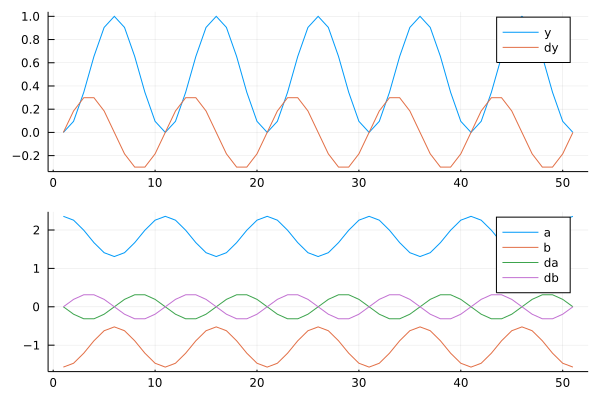

In [25]:
begin
    x = 0:50
    y = 0.5 .- 0.5*cos.((pi/5) .* x)
    t =  0:5
    println(t[6])
    a = 3*pi/4 .- pi/6*(1 .- cos.(pi/5 .* x))
    b = -pi/2 .+ pi/6*(1 .- cos.(pi/5 .* x))
    dy = 0.5*sin.(pi/5 .* x)*pi/5
    da = -((pi^2)/30)*sin.((pi/5) .* x)
    db = -da
    println(sum(da[1:6]))
    println(a[6] - a[1])
    p1 = plot(y, labels="y")
    plot!(dy, labels="dy")
    # plot(x)
    p2 = plot(a, labels="a")
    plot!(b, labels="b")
    # plot!(a+b)
    plot!(da, labels="da")
    plot!(db, labels="db")
    
    plot(p1, p2, layout = (2, 1), legend = true)
    
    
    # println(a[5])
end

In [158]:
function ref_traj(nlp, ymax)
    N = nlp.N
    xLen = length(nlp.xinds[1])
    uLen = length(nlp.uinds[1])
    
    xref = zeros(xLen, N)
    uref = zeros(uLen, N-1)
    
    ueq = [123.0, 123.0]
    for i = 1:(N-1)
        t = i - 1
        xref[1, i] = 0.0
        xref[2, i] = ymax - ymax*cos(t*pi/5)
        xref[3, i] = 3*pi/4 - pi/6*(1 - cos(t*pi/5))
        xref[4, i] = -pi/2 + pi/6*(1 - cos(t*pi/5))
        xref[5, i] = 0.0
        xref[6, i] = (ymax*pi/5)*sin(pi/5*t)
        xref[7, i] = -((pi^2)/30)*sin((pi/5)*t)
        xref[8, i] = ((pi^2)/30)*sin((pi/5)*t)
        if mod(i, nlp.mSteps) == 1
            uref[:, i] .= ueq
        end
    end
    xref[:, end] .= nlp.xf
    Xref = [SVector{xLen}(x) for x in eachcol(xref)]
    Uref = [SVector{uLen}(u) for u in eachcol(uref)]
    return Xref, Uref
end

ref_traj (generic function with 1 method)

[0.0, 0.0]


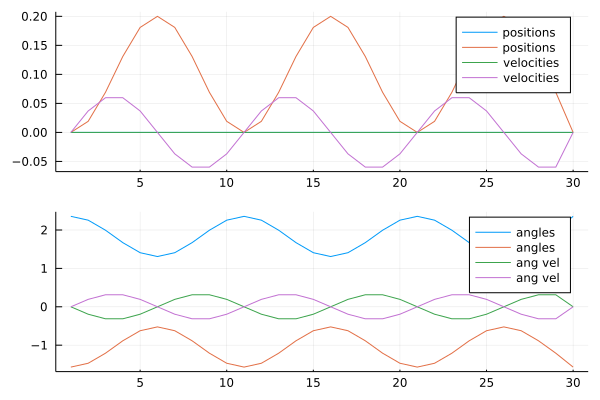

In [160]:
# Testing the reference trajectory
begin
    x0 = zeros(8)
    x0[3] = 3*pi/4
    x0[4] = -pi/2
    xf = x0
    u0 = zeros(2)
    hopper = Hopper(1, 2, 1, 0.5, 0.5)
    tf = 10.0
    mSteps = 5
    Qf = I(8)
    Q = Qf * 0.01
    R = I(2) * 0.01
    N = 30
    
    p = HybridNlp(hopper, Q, R, Qf, tf, N, mSteps, x0, xf, 0.1)
    xtraj, utraj = ref_traj(p, 0.1)
    p1 = plot(xtraj, inds=1:2, labels="positions")
    # plot!(xtraj, inds=2, labels="y")
    plot!(xtraj, inds=5:6, labels="velocities")
    # plot!(xtraj[6, :], labels="dy")
    # plot(x)
    p2 = plot(xtraj, inds=3:4, labels="angles")
    plot!(xtraj, inds=7:8, labels="ang vel")
    # plot!(a+b)
    # plot!(xtraj[7, :], labels="da")
    # plot!(xtraj[8, :], labels="db")
    println(utraj[7])
    plot(p1, p2, layout = (2, 1), legend = true)
end

Creating NLP Block Data...
Creating Ipopt...
Adding constraints...
starting Ipopt Solve...
This is Ipopt version 3.13.4, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:    88396
Number of nonzeros in inequality constraint Jacobian.:    19096
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      308
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      287
Total number of inequality constraints...............:       62
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       62
        inequality constraints with only upper bounds:       

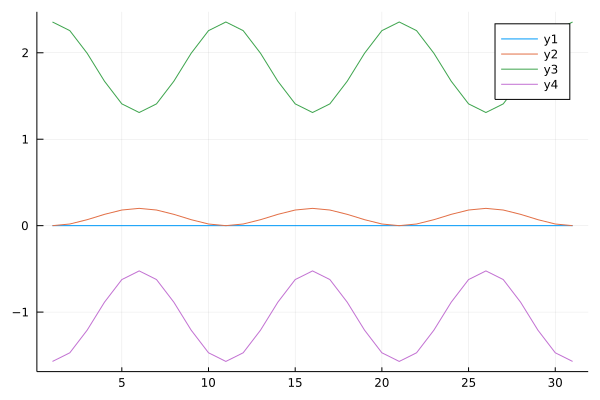

In [159]:
# Run the solver
begin
    x0 = zeros(8)
    x0[3] = 3*pi/4
    x0[4] = -pi/2
    xf = x0
    u0 = zeros(2)
    hopper = Hopper(1, 2, 1, 0.5, 0.5)
    h = 0.05
    mSteps = 5
    Qf = I(8) * 0.01
    Q = Qf
    R = I(2) * 0.001
    N = 31
    tf = (N - 1)*h

    p = HybridNlp(hopper, Q, R, Qf, tf, N, mSteps, x0, xf, 0.1)
    Xref, Uref = ref_traj(p, 0.1)
    # println(nlp.uinds)

    Zref = pack(p, Xref, Uref)
    # println(size(Zref))
    Zout, solver = solve(Zref, p, c_tol=1e-2, tol=1e-2)
    Xout, Uout = unpack(p, Zout)
    plot(Xout, inds=1:4)
    # println(Xout)
end